In [1]:
%load_ext autoreload
%autoreload 2

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Plotting Params
palette={
    "nj_iwhd_oracle": "green",
    "nj_iwhd": "firebrick", 
    "nj": "royalblue"
}
hue_order=[
    "nj_iwhd_oracle",
    'nj_iwhd', 
    'nj'
]

In [102]:
# Load Each CSV
RF_df_iwhd = pd.read_csv("data/scores/nj_iwhd.robinson_foulds.tsv", sep="\t")
triplets_df_iwhd = pd.read_csv("data/scores/nj_iwhd.triplets_correct.tsv", sep="\t")

RF_df_nj = pd.read_csv("data/scores/nj.robinson_foulds.tsv", sep="\t")
triplets_df_nj = pd.read_csv("data/scores/nj.triplets_correct.tsv", sep="\t")

RF_df_nj_iwhd_oracle = pd.read_csv("data/scores/nj_iwhd_oracle.robinson_foulds.tsv", sep="\t")
triplets_df_nj_iwhd_oracle = pd.read_csv("data/scores/nj_iwhd_oracle.triplets_correct.tsv", sep="\t")

# Concat all dfs
RF_df = pd.concat([RF_df_iwhd, RF_df_nj, RF_df_nj_iwhd_oracle])
triplets_df = pd.concat([triplets_df_iwhd, triplets_df_nj, triplets_df_nj_iwhd_oracle])

RF_df.head()

,NumberOfCells,Priors,Fitness,Stressor,Parameter,Algorithm,Replicate,UnNormalizedRobinsonFoulds,MaxRobinsonFoulds,NormalizedRobinsonFoulds
0,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,5,1754,3556,0.493251
1,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,31,1863,3495,0.533047
2,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,46,2017,3461,0.582780
3,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,10,1884,3488,0.540138
4,2000,no_priors,no_fit,stoch_high_drop,30,nj_iwhd,28,1656,3500,0.473143


In [180]:
# Grouping
group_cols_by = [
    "Algorithm",
    "Replicate",
    "Fitness",
    "Stressor",
    "Parameter"
]

RF_df_grouped = RF_df.groupby(group_cols_by, as_index=False).mean()
triplets_df_grouped = triplets_df.groupby(group_cols_by, as_index=False).mean().drop(columns=['Depth'])

# Get "Name" Column
name_col_includes = [
    "Fitness",
    "Stressor",
    "Parameter"
]

def apply_name(row):
    list_name = [str(row[col]) for col in name_col_includes]
    return ' | '.join(list_name)


RF_df_grouped['name'] = RF_df_grouped.apply(apply_name, axis=1)
triplets_df_grouped['name'] = triplets_df_grouped.apply(apply_name, axis=1)

In [173]:
np.tile(RF_df_grouped.groupby(name_col_includes, as_index=False).count()['Fitness'].value_counts().sort_index().values, 2).cumsum()

array([21, 42, 63, 84])

In [175]:
def get_stressor_dividers(df, colname, repeats):
    out = df.groupby(name_col_includes, as_index=False).count()[colname].value_counts().sort_index().values
    out = np.tile(out, repeats)
    out = out[:-1].cumsum()
    out = out / repeats - 0.5
    return out

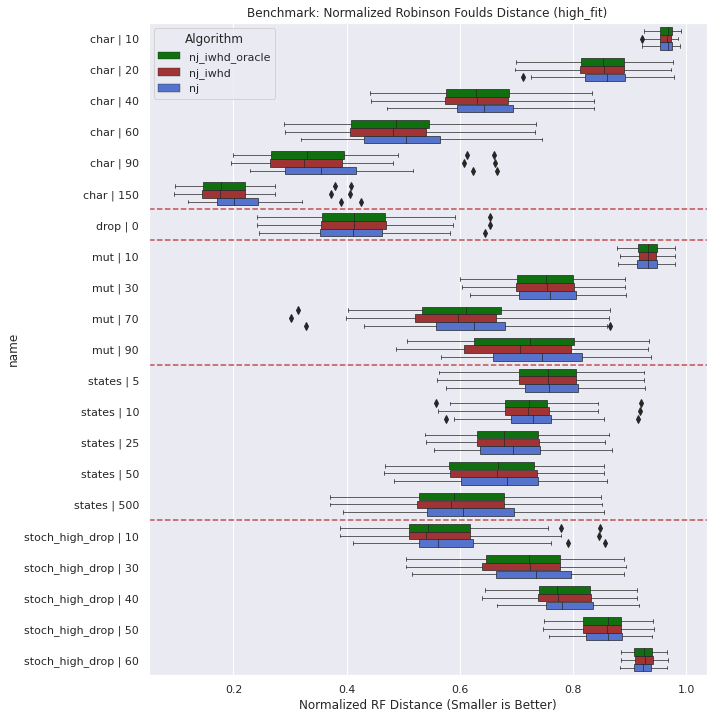

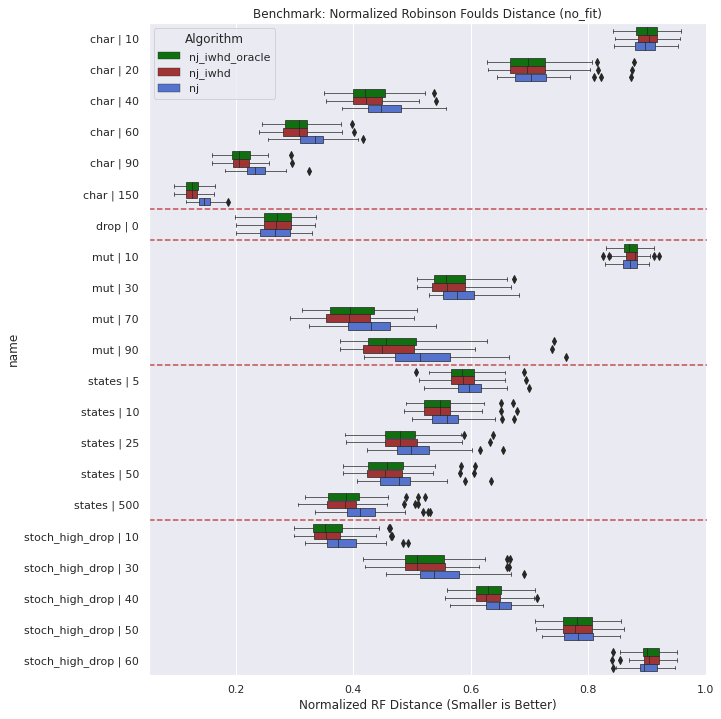

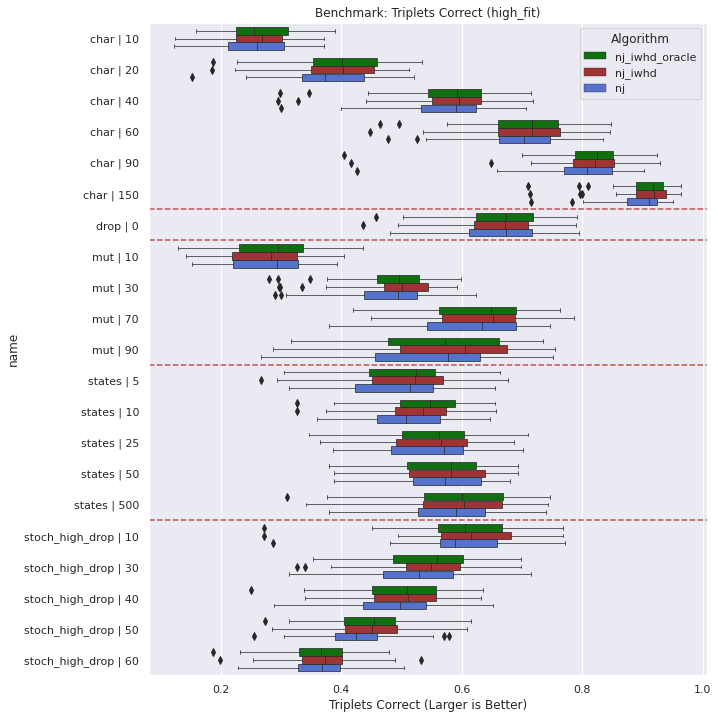

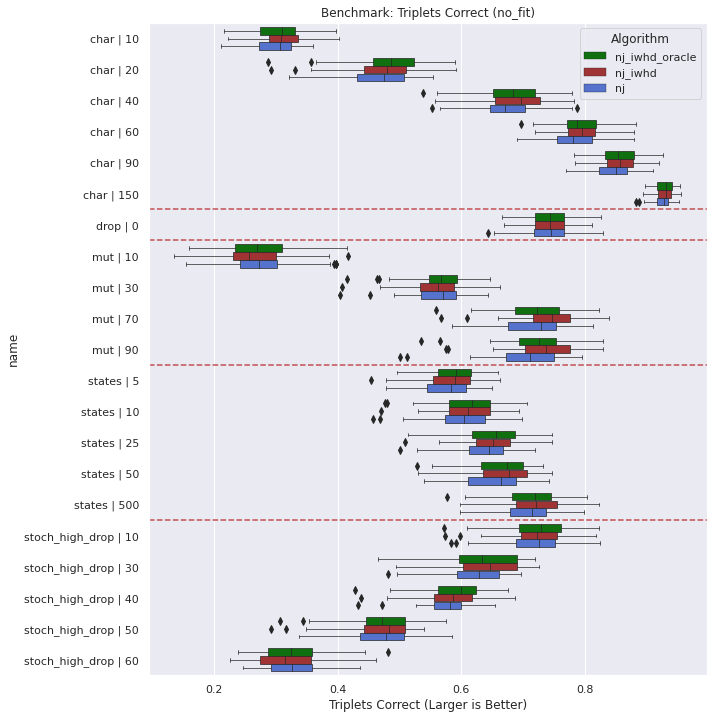

In [187]:
sns.set(rc={'figure.figsize': (10, 12)})

# Plot metrics
rf_vars = {
    'df': RF_df_grouped,
    'title': 'Benchmark: Normalized Robinson Foulds Distance',
    'x_label': 'Normalized RF Distance (Smaller is Better)',
    'outfile': 'plots/rf_benchmark',
    'colname': 'NormalizedRobinsonFoulds'
}
triplets_vars = {
    'df': triplets_df_grouped,
    'title': 'Benchmark: Triplets Correct',
    'x_label': 'Triplets Correct (Larger is Better)',
    'outfile': 'plots/triplets_benchmark',
    'colname': 'TripletsCorrect'
}

for vars in [rf_vars, triplets_vars]:
    for fitness in vars['df']['Fitness'].unique():
        df = vars['df'][vars['df']['Fitness'] == fitness]
        # Main Boxplot
        bp = sns.boxplot(
            y='name', 
            x=vars['colname'],
            data=df, 
            hue='Algorithm', 
            width=0.75,
            palette=palette,
            hue_order=hue_order,
            linewidth=0.7
            )

        # Plot Dividers
        stressor_divisions = get_stressor_dividers(df, 'Stressor', 1)
        fitness_divisions = get_stressor_dividers(df, 'Fitness', 1) 
        [plt.axhline(y, color = 'r', linestyle='--') for y in stressor_divisions]
        [plt.axhline(y, color = 'b', linestyle='--') for y in fitness_divisions]

        # Visuals
        plt.title(vars['title'] + f' ({fitness})')
        plt.xlabel(vars['x_label'])
        # plt.grid(which='major')
        plt.savefig(vars['outfile'] + '.' + fitness + '.png', dpi=300)
        plt.show()